In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import sklearn
import sklearn.neighbors
from pathlib import Path
from pandas.api.types import CategoricalDtype
from operator import itemgetter
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import KElbowVisualizer
import torch
from scipy.sparse import dok_matrix

import warnings
warnings.filterwarnings('ignore')

# Constants
RAW_DATA_PATH = Path('raw_data/')
DATAFRAME_PATH = Path('dataframes/')
MODEL_PATH = Path('model/ncf_model.pt')
TOTAL_TRACKS = 50
NUM_WITHHELD = 25
N_NEIGHBORS = 500
SELECTED_TRACK_FEATURES = ['danceability', 'energy', 'speechiness', 'acousticness', 'instrumentalness',  'liveness', 'valence',
                           'tempo','key', 'loudness',
                          ]

In [2]:
# Use GPU when possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

## Data Preparation

In [3]:
# Load h5 files created from pre-processing notebook 
tracks_features_df = pd.read_hdf(DATAFRAME_PATH / 'tracks_features_df.h5', 'tracks_features_df')
cat_type = CategoricalDtype(categories=tracks_features_df.tid, ordered=True)
tracks_features_df.tid = tracks_features_df.tid.astype(cat_type)
playlist_tracks_df = pd.read_hdf(DATAFRAME_PATH/'playlist_tracks_df.h5', 'playlist_tracks_df')
playlist_tracks_df.tid = playlist_tracks_df.tid.astype(cat_type)
playlists_info_df = pd.read_hdf(DATAFRAME_PATH/'playlists_info_df.h5', 'playlists_info_df')
artists_genres_df = pd.read_hdf(DATAFRAME_PATH/'artists_genres_df.h5', 'artists_genres_df')

# Display sample rows from each dataframe
display(tracks_features_df.sample(2))
display(playlist_tracks_df.sample(2))
display(playlists_info_df.head(2))
display(artists_genres_df.sample(2))

,tid,uri,artist_name,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
142507,142507,spotify:track:6WapEECDUdOaUdT2tAXPCu,Vinyl Thief,Here in the Moment,0.712,0.713,3,-7.051,1,0.1540,0.3450,0.4030,0.140,0.845,140.963,211064,4
82457,82457,spotify:track:3lowgSQQTevp4MuJlauChK,Harlem Style,Girl You Know It's True - Gangnam Shake Edit,0.609,0.940,1,-10.062,1,0.0437,0.0173,0.0276,0.571,0.599,145.008,216346,4


,tid,uri,pid,pos
587520,3978,spotify:track:0AvweyeTt730W1pQd7wOi8,8781,62
119765,91675,spotify:track:4BycRneKmOs6MhYG9THsuX,1788,25


,pid,playlist_name
0,0,Throwbacks
1,1,Awesome Playlist


,artist_uri,artist_name,genres
2166,spotify:artist:2UBTfUoLI07iRqGeUrwhZh,Steve Earle,"alternative country,country rock,folk,folk roc..."
19515,spotify:artist:6gWsNpg9lhVbimwQ8bP5K1,YONAS,"indie pop rap,pop rap"


### Scale Track Features

In [4]:
# Scale features before feeding to the knn model
scaler = MinMaxScaler()
tracks_features_df[SELECTED_TRACK_FEATURES] = pd.DataFrame(scaler.fit_transform(tracks_features_df[SELECTED_TRACK_FEATURES]), columns=SELECTED_TRACK_FEATURES)
tracks_features_df[SELECTED_TRACK_FEATURES]

,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,loudness
0,0.921292,0.748,0.044444,0.074799,0.000957,0.0403,0.864,0.484106,0.818182,0.903770
1,0.448032,0.991,0.138110,0.000085,0.000084,0.1200,0.106,0.525980,0.636364,0.889542
2,0.305752,0.616,0.038733,0.243976,0.000003,0.1340,0.219,0.333670,0.909091,0.821018
3,0.754793,0.627,0.066355,0.131526,0.000000,0.0852,0.524,0.513031,0.636364,0.859876
4,0.531786,0.793,0.036552,0.108434,0.000003,0.1440,0.597,0.530123,0.272727,0.879091
...,...,...,...,...,...,...,...,...,...,...
170084,0.710394,0.899,0.063344,0.037851,0.001011,0.3340,0.407,0.462310,0.545455,0.861055
170085,0.648840,0.922,0.045379,0.194779,0.778779,0.1470,0.605,0.508883,0.636364,0.861342
170086,0.604440,0.525,0.041225,0.731928,0.000046,0.0909,0.186,0.490561,0.818182,0.848469
170087,0.750757,0.581,0.151610,0.595382,0.958959,0.2040,0.679,0.538254,0.727273,0.793025


In [5]:
all_playlist_ids = playlist_tracks_df.pid.unique()
train_pids, test_pids = train_test_split(all_playlist_ids,random_state=0, test_size=0.20)
print(f'total playlists: {len(all_playlist_ids)}')
print(f'train playlists: {len(train_pids)}')
print(f'test playlists: {len(test_pids)}')

# 1. Get tracks that are only from the training playlists
# 2. Get the track features(danceability,loudness) for each of these training tracks
# 3. Make a test set that only includes tracks from the training set
train_playlist_tracks_df = playlist_tracks_df.query('pid in @train_pids')
train_tracks_features_df = tracks_features_df.query('tid in @train_playlist_tracks_df.tid')
test_playlist_tracks_df = playlist_tracks_df.query('pid in @test_pids and tid in @train_playlist_tracks_df.tid')
print()
print(f'total tracks in train playlists: {len(train_playlist_tracks_df)}')
print(f'unique tracks in train playlists: {len(train_tracks_features_df)}')


# 1. Get the first NUM_WITHHELD tracks for each playlist in test
# 2. Get the track features for these with held tracks
# 3. Compute mean features by grouping the tracks from incomplete playlists
test_playlist_tracks_incomplete_df = test_playlist_tracks_df.groupby('pid').head(NUM_WITHHELD)
test_tracks_incomplete_features_df = test_playlist_tracks_incomplete_df.merge(tracks_features_df,how='inner',on='tid')
test_playlist_incomplete_features = test_tracks_incomplete_features_df[['pid',*SELECTED_TRACK_FEATURES]].groupby('pid',as_index=False).mean()
print()
print(f'total tracks in test playlists: {len(test_playlist_tracks_df)}')
print(f'total tracks in incomplete test playlists: {len(test_playlist_tracks_incomplete_df)}')
print(f'total incomplete test playlists: {len(test_playlist_incomplete_features)}')

total playlists: 10000
train playlists: 8000
test playlists: 2000

total tracks in train playlists: 532827
unique tracks in train playlists: 147296

total tracks in test playlists: 107713
total tracks in incomplete test playlists: 42362
total incomplete test playlists: 1988


## K-Nearest Neighbors (on tracks)

In [6]:
# KNN model that will find 25 nearest neighbors to the current playlist
knn_clf = sklearn.neighbors.NearestNeighbors(n_neighbors=N_NEIGHBORS)
knn_clf.fit(train_tracks_features_df[SELECTED_TRACK_FEATURES])
distances, indices = knn_clf.kneighbors(test_playlist_incomplete_features[SELECTED_TRACK_FEATURES])

In [7]:
# For each test playlist, get the 25 next nearest predicted tracks and add them to a table for evaluation
def get_predicted_playlist_tracks():
    for index, row in test_playlist_incomplete_features.iterrows():
            predicted_tracks = train_tracks_features_df['tid'].iloc[indices[index]]
            for pos, predicted_track in enumerate(predicted_tracks):
                yield predicted_track, int(row['pid']),pos

test_predicted_playlist_tracks_df = pd.DataFrame(get_predicted_playlist_tracks(), columns =['tid', 'pid', 'pos'])

In [8]:
# A sample row from the "test" set which has only seed tracks
one_pid = test_playlist_incomplete_features.sample(1)
one_pid

,pid,danceability,energy,speechiness,acousticness,instrumentalness,liveness,valence,tempo,key,loudness
233,1257,0.675318,0.70328,0.076943,0.098925,0.018449,0.174268,0.505088,0.479627,0.552727,0.866093


In [9]:
# Show recommendations by KNN for one random playlist
tracks_in_one_playlist_df = test_predicted_playlist_tracks_df.query('pid in @one_pid.pid')
tracks_info_in_one_playlist_df = tracks_features_df.query('tid in @tracks_in_one_playlist_df.tid')
print('recommendations for ',playlists_info_df.query('pid in @one_pid.pid')['playlist_name'].head(1).values)
tracks_info_in_one_playlist_df = tracks_info_in_one_playlist_df[['artist_name','track_name']]
tracks_info_in_one_playlist_df['distances'] = distances[one_pid.index].reshape(-1,1)
tracks_info_in_one_playlist_df

recommendations for  ['40th ']


,artist_name,track_name,distances
3,ZAYN,Still Got Time,0.089075
604,Naïka,Ride,0.089946
621,K CAMP,Good Weed Bad B*tch,0.097935
818,Phoebe Ryan,Mine,0.109546
1150,Insane Clown Posse,If I Was a Serial Killer,0.110819
...,...,...,...
169043,Ciara,Keep Dancin' On Me,0.189869
169321,Chris Brown,Thank You,0.189879
169850,Zac Brown Band,Keep Me In Mind,0.190086
169895,Vybz Kartel,Repartriation,0.190144


In [10]:
# Class containing the methods for evaluating the models
class Evaluator:
    def __init__(self,predicted_playlist_tracks,true_playlist_tracks):
        self.predicted_playlist_tracks = predicted_playlist_tracks
        self.true_playlist_tracks = true_playlist_tracks    

    def evaluate(self):
        predicted_playlist_tracks = self.predicted_playlist_tracks
        true_playlist_tracks = self.true_playlist_tracks
        
        r_precision_list = []
        ndcg_list = []
        song_clicks_list = []
        
        pid_list = predicted_playlist_tracks.pid.unique()
        
        def get_metrics():
            for pid in tqdm(pid_list):
                predictions = predicted_playlist_tracks.query('pid == @pid')
                truth = true_playlist_tracks.query('pid == @pid')
                r_precision_tracks,r_precision_artists,r_precision_genres = self.r_precision(predictions,truth)
                yield (pid , 
                       r_precision_tracks,
                       r_precision_artists,
                       r_precision_genres,
                       self.ndcg(predictions,truth),
                       self.song_clicks(predictions,truth),
                      )
        metrics = pd.DataFrame(get_metrics(),columns=[
            'pid',
            'r_precision_tracks','r_precision_artists','r_precision_genres',
            'ndcg',
            'songs_click'
        ])
        
        return metrics[['r_precision_tracks','r_precision_artists','r_precision_genres',
                        'ndcg','songs_click'
                       ]].mean()
         
    def r_precision(self,predictions,truth):
        truth_set = set(truth.tid)
        n_tracks = len(truth_set)
        prediction_set = set(predictions[:n_tracks].tid)
        intersect = prediction_set.intersection(truth_set)
        
        truth_set_artists =  set(truth.artist_name)
        prediction_set_artists =  set(predictions[:n_tracks].artist_name)
        intersection_artists = prediction_set_artists.intersection(truth_set_artists)

        truth_set_genres =  truth['genres'].str.split(',').explode().unique()
        prediction_set_genres =  predictions[:n_tracks].genres.str.split(',').explode().unique()
        intersection_genres = np.intersect1d(prediction_set_genres,truth_set_genres)
        
        if len(truth_set) == 0:
            tracks_pr = 0
        else:
            tracks_pr = float(len(intersect)) / len(truth_set)
        if len(truth_set_artists) == 0:
            artists_pr = 0
        else:
            artists_pr = float(len(intersection_artists)) / len(truth_set_artists)
        if len(truth_set_genres) == 0:
            genres_pr = 0
        else: 
            genres_pr = float(len(intersection_genres)) / len(truth_set_genres)
        return tracks_pr, artists_pr,genres_pr
            
    def ndcg(self,predictions,truth):
        truth = list(truth.tid)
        n_tracks = len(truth)
        predictions = list(predictions.tid.iloc[:n_tracks])
        score = [float(element in truth) for element in predictions]  
        dcg  = np.sum(score / np.log2(1 + np.arange(1, len(score) + 1)))     
        ones = np.ones([1,len(truth)])
        idcg = np.sum(ones / np.log2(1 + np.arange(1, len(truth) + 1)))
        return (dcg / idcg)
    
    def song_clicks(self,predictions,truth):
        n_tracks = len(truth)
        truth = truth.tid
        predictions = predictions.tid[:n_tracks]
        i = set(predictions).intersection(set(truth))
        for index, t in enumerate(predictions):
            for track in i:
                if t == track:
                    return float(int(index / 10))              
        return float(n_tracks / 10.0 + 1)

In [11]:
# Join the dataframes to get genres too for each track
temp_df = test_predicted_playlist_tracks_df.merge(tracks_features_df[['tid','track_name','artist_name']],on='tid')
test_predicted_playlist_tracks_genres_df = temp_df.merge(artists_genres_df[['artist_name','genres']],on='artist_name')
temp_df = test_playlist_tracks_df.groupby('pid').apply(lambda tracks: tracks.iloc[25:])
temp_df = temp_df.merge(tracks_features_df[['tid','track_name','artist_name']],on='tid')
test_playlist_tracks_genres_df = temp_df.merge(artists_genres_df[['artist_name','genres']],on='artist_name')

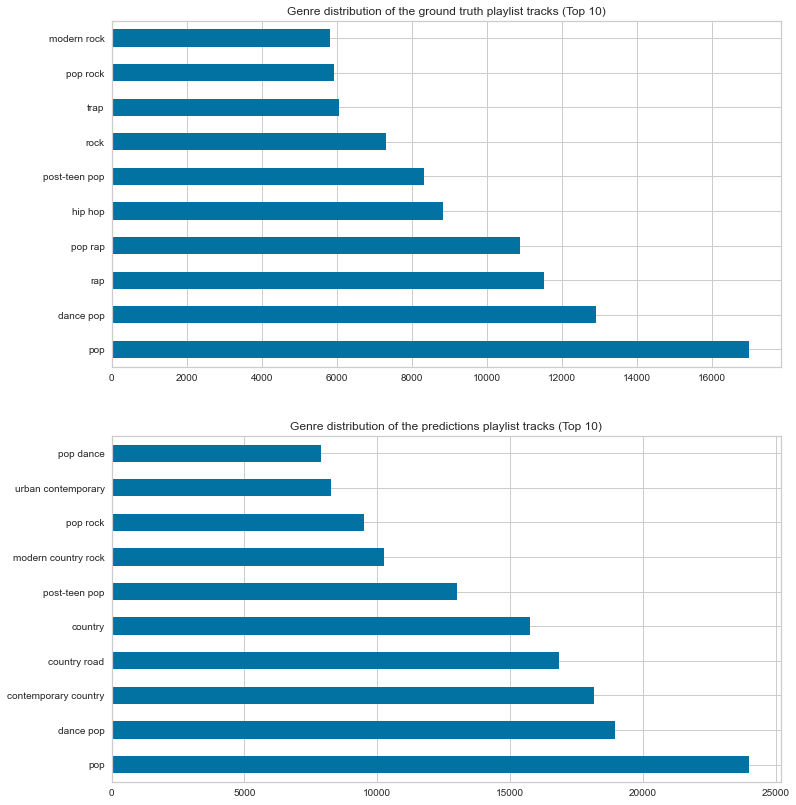

In [12]:
# Plot the genre distributions for tracks in ground truth and predicted playlists
def plot_genre_distributions(preds_df, gt_df, use_avg=False):
    if use_avg:
        avg_gt_len = int(gt_df.groupby('pid').size().mean())
    else:
        avg_gt_len = len(gt_df)
    preds_df = preds_df.groupby('pid').head(avg_gt_len)
    truth_genres =  gt_df['genres'].str.split(',').explode().replace('', np.nan).dropna()
    prediction_set_genres =  preds_df.genres.str.split(',').explode().replace('', np.nan).dropna()
    plt.figure(figsize=(12,14))
    plt.subplot(211)
    plt.title('Genre distribution of the ground truth playlist tracks (Top 10)')
    truth_genres.value_counts()[:10].plot(kind='barh')
    plt.subplot(212)
    plt.title('Genre distribution of the predictions playlist tracks (Top 10)')
    prediction_set_genres.value_counts()[:10].plot(kind='barh')

plot_genre_distributions(test_predicted_playlist_tracks_genres_df,test_playlist_tracks_genres_df, use_avg=True)

In [13]:
# Evaluate the KNN model
model_eval = Evaluator(test_predicted_playlist_tracks_genres_df,test_playlist_tracks_genres_df)
model_eval.evaluate()

100%|██████████| 1988/1988 [00:20<00:00, 97.08it/s] 


r_precision_tracks     0.000834
r_precision_artists    0.018902
r_precision_genres     0.233393
ndcg                   0.001280
songs_click            3.922032
dtype: float64

## Neural Matrix Factorization Model (on playlists)

In [14]:
# Create the training data: a sparse matrix of playlists x tracks
total_playlist_tracks_df = train_playlist_tracks_df.append(test_playlist_tracks_incomplete_df)
unique_tracks = total_playlist_tracks_df['tid'].unique()
total_cat_type = CategoricalDtype(categories=unique_tracks, ordered=True)
total_playlist_tracks_df['tid'] = total_playlist_tracks_df.tid.astype(total_cat_type)
total_playlist_tracks_df['cat_codes'] = total_playlist_tracks_df['tid'].cat.codes

dok_mat_n_rows = total_playlist_tracks_df.pid.unique().max() + 1
dok_mat_n_cols = len(unique_tracks)

dok_mat_rows = total_playlist_tracks_df['pid']
dok_mat_cols = total_playlist_tracks_df['cat_codes']

# Make a dictionary key sparse matrix
dok_mat = dok_matrix((dok_mat_n_rows, dok_mat_n_cols))

# TODO vectorize later if possible
for (pid, cat_code) in tqdm(zip(dok_mat_rows, dok_mat_cols)):
    dok_mat[pid, cat_code] = 1.0

575189it [00:07, 80091.46it/s]


In [15]:
rand_negative_fill_in = 4
layer_sizes = [64, 32, 16, 8]

# Hyperparameters
embedding_dim = 8
num_epochs = 5
learning_rate = 0.001
batch_size = 200

In [16]:
# The model class
class NeuralMF(torch.nn.Module):
    def __init__(self, num_pl, num_tr, dim=embedding_dim):
        super(NeuralMF, self).__init__()
        num_of_layers = len(layer_sizes)
        
        # Embedding layers
        self.pl_embedding = torch.nn.Embedding(num_pl, dim)
        self.tr_embedding = torch.nn.Embedding(num_tr, dim)
        self.pl_mlp_embedding = torch.nn.Embedding(num_pl, int(layer_sizes[0]/2))
        self.tr_mlp_embedding = torch.nn.Embedding(num_tr, int(layer_sizes[0]/2))
        
        # Linear layers in MLP
        self.mlp = torch.nn.ModuleList()
        for i in range(1, num_of_layers):
            self.mlp.append(torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            self.mlp.append(torch.nn.ReLU())

        self.affine_final = torch.nn.Linear(dim + layer_sizes[-1], 1)
        self.logistic_sig = torch.nn.Sigmoid()
    
    def init_weight(self):
        torch.nn.init.normal_(self.pl_embedding, std=0.01)
        torch.nn.init.normal_(self.tr_embedding, std=0.01)
        torch.nn.init.normal_(self.pl_mlp_embedding, std=0.01)
        torch.nn.init.normal_(self.tr_mlp_embedding, std=0.01)
        
        for layer in self.mlp:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                
        torch.nn.init.xavier_uniform_(self.affine_final.weight)
        
        for mod in self.modules():
            if isinstance(mod, torch.nn.Linear) and mod.bias is not None:
                mod.bias.data.zero_()
        
    def forward(self, playlists, tracks):
        pl_vec = self.pl_embedding(playlists)
        tr_vec = self.tr_embedding(tracks)
        # multiply/cross the playlist and tracks factors
        prod = torch.mul(pl_vec, tr_vec)
        
        pl_mlp_vec = self.pl_mlp_embedding(playlists)
        tr_mlp_vec = self.tr_mlp_embedding(tracks)
        # concatenate the playlist and tracks vectors
        mlp_vec = torch.cat([pl_mlp_vec, tr_mlp_vec], dim=-1)
        
        # pass through the linear layers
        for i, layer in enumerate(self.mlp):
            mlp_vec = layer(mlp_vec)
        
        # affine last layer
        result = self.affine_final(torch.cat([prod,mlp_vec], dim=-1))
        # activated output layer
        activated_result = self.logistic_sig(result)
        return torch.flatten(activated_result)

In [46]:
# The training loop and utilities
model = NeuralMF(dok_mat.shape[0], dok_mat.shape[1])
model.to(device)
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

def plot_loss(iters, losses):
    plt.plot(iters, losses)
    plt.title(f'Training Curve (batch_size={batch_size}, lr={learning_rate})')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

def make_train_data():
    for (pl, tr) in dok_mat.keys():
        yield pl, tr, 1.0
        for t in range(rand_negative_fill_in):
            rand_num = np.random.randint(dok_mat.shape[1])
            while(pl, rand_num) in dok_mat.keys():
                rand_num = np.random.randint(dok_mat.shape[1])
            yield pl, rand_num, 0.0

def train_loop(data_loader):
    losses = []; iters = []; offset = 0
    for epoch in range(num_epochs):
        for idx, (pl, tr, recs) in enumerate(tqdm(data_loader)):
            pl, tr, recs = pl.to(device), tr.to(device), recs.to(device)
            recs = recs.float()
            optim.zero_grad()
            out = model(pl,tr)
            loss = loss_fn(out, recs)
            losses.append(loss)
            iters.append(offset+idx)
            loss.backward()
            optim.step()
        offset = iters[-1]
        print(f'training loss after epoch-{epoch+1} = {(losses[-1]):.4f}')
    return iters, losses

def run_training():
    data_loader = torch.utils.data.DataLoader(list(make_train_data()), batch_size=batch_size)
    return train_loop(data_loader)

  0%|          | 3/14203 [00:00<08:58, 26.36it/s]

training loss after epoch-1 = 0.2307


  0%|          | 3/14203 [00:00<08:39, 27.35it/s]

training loss after epoch-2 = 0.2166


  0%|          | 3/14203 [00:00<08:26, 28.05it/s]

training loss after epoch-3 = 0.1994


  0%|          | 3/14203 [00:00<09:10, 25.77it/s]

training loss after epoch-4 = 0.1891


100%|██████████| 14203/14203 [08:26<00:00, 28.05it/s]


training loss after epoch-5 = 0.1917


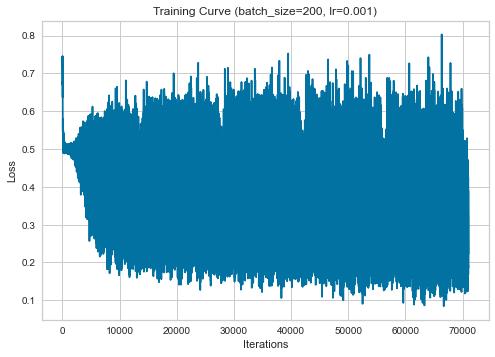

In [18]:
# Run the training, save the model and plot the loss
iters, losses = run_training()
torch.save(model.state_dict(), MODEL_PATH)
plot_loss(iters, losses)

In [ ]:
# Load the saved model
model.load_state_dict(torch.load(MODEL_PATH, map_location=device)) #👌 

## Make recommendations using the NeuMF model

In [19]:
# Other utility dataframes
unique_playlist_tracks_df = total_playlist_tracks_df.drop_duplicates(subset=['cat_codes'])
unique_playlist_tracks_df = unique_playlist_tracks_df.sort_values(by=['cat_codes'], ascending=False)

unique_tids_by_cat_codes = np.array(unique_playlist_tracks_df['tid'])
unique_result_merged = unique_playlist_tracks_df.merge(tracks_features_df, on='tid')
other_features_by_cat_codes = np.array([(row['track_name'],row['artist_name']) for i, row in unique_result_merged.iterrows()])

In [44]:
# Methods to get predictions for each test playlist
def get_results_df(results_df):
    for i, probability in enumerate(results_df):
        tid = unique_tids_by_cat_codes[i]
        other_features = other_features_by_cat_codes[i]
        yield probability.item(), tid, *other_features

def predictions_nmf(nmf_preds, pid):
    for idx,row in nmf_preds.iterrows():
        yield (row['tid'], pid, idx, row['probability'])
        
def run_hyperparam_search(weight_mat):
    km_model = KMeans()
    visualizer = KElbowVisualizer(km_model, k=(50,100))
    visualizer.fit(weight_mat.detach().cpu().numpy())
    visualizer.show()
        
def make_predictions_nmf(playlists_for_test, run_hyperparam_search=False):
    playlist_embedding_weight_matrix = model.pl_mlp_embedding.weight
    chosen_playlist_vectors = playlist_embedding_weight_matrix[playlists_for_test]
    
    # Run hyperparam search if required
    if run_hyperparam_search:
        run_hyperparam_search(playlist_embedding_weight_matrix)
        
    # Fit a KMeans model with 100 clusters
    km_model = KMeans(n_clusters=100, random_state=0, verbose=0).fit(playlist_embedding_weight_matrix.detach().cpu().numpy())
    
    for chosen_pid, chosen_playlist_vector in tqdm(zip(playlists_for_test,chosen_playlist_vectors)):
        chosen_playlist_vector = chosen_playlist_vector.detach().cpu().numpy().reshape(1,-1)
        chosen_playlist_cluster = km_model.predict(chosen_playlist_vector)
        playlist_labels = km_model.labels_
        
        # Get other playlists in the same cluster
        similar_playlists = []
        for pid, playlist_label in enumerate(playlist_labels):
            if playlist_label == chosen_playlist_cluster:
                similar_playlists.append(pid)
        
        # append tracks from those playlists
        tracks = []
        tracks = total_playlist_tracks_df.query('pid in @similar_playlists')['cat_codes']

        pids_pred = torch.tensor(np.full(len(tracks), chosen_pid, dtype='int32')).to(device)
        tracks_pred = torch.tensor(np.array(tracks, dtype='int32')).to(device)

        # Make predictions with the trained NeuMF model
        results = model(pids_pred, tracks_pred)

        results_df = pd.DataFrame(get_results_df(results), index=range(len(results)), columns=['probability', 'tid','track_name', 'artist_name'])
        results_df = results_df.sort_values(by=['probability'], ascending=False)
        total_tracks = len(ground_truth.query('pid == @chosen_pid'))
        
        num_recommendations = total_tracks - NUM_WITHHELD
        
        # skip if there are no recommendations to make
        if num_recommendations <= 0:
            continue

        nmf_preds = results_df.head(num_recommendations)
        predictions_nmf_df = pd.DataFrame(predictions_nmf(nmf_preds,chosen_pid), columns=['tid','pid', 'pos','probability'])
        
        # merge dataframes so as to also get the genres
        predictions_nmf_genres_df = predictions_nmf_df
        temp_df = predictions_nmf_genres_df.merge(tracks_features_df[['tid','track_name','artist_name']],on='tid')
        predictions_nmf_genres_df = temp_df.merge(artists_genres_df[['artist_name','genres']],on='artist_name')
        
        yield predictions_nmf_genres_df

In [ ]:
# Make predictions
playlists_for_test = test_playlist_tracks_df['pid'].unique()
ground_truth = test_playlist_tracks_df.query('pid in @playlists_for_test')
ground_truth_genres_df = ground_truth.groupby('pid').apply(lambda tracks: tracks.iloc[25:])
temp_df = ground_truth_genres_df.merge(tracks_features_df[['tid','track_name','artist_name']],on='tid')
ground_truth_genres_df = temp_df.merge(artists_genres_df[['artist_name','genres']],on='artist_name')

model.eval()

pred_gen = make_predictions_nmf(playlists_for_test)
first_pred = next(pred_gen)
preds_df = first_pred.append(list(pred_gen))

In [23]:
# Evaluate the NeuMF model
nmf_model_eval = Evaluator(preds_df, ground_truth_genres_df)
nmf_model_eval.evaluate()

100%|██████████| 1323/1323 [00:08<00:00, 159.80it/s]


r_precision_tracks     0.000322
r_precision_artists    0.014513
r_precision_genres     0.350180
ndcg                   0.000311
songs_click            5.904686
dtype: float64

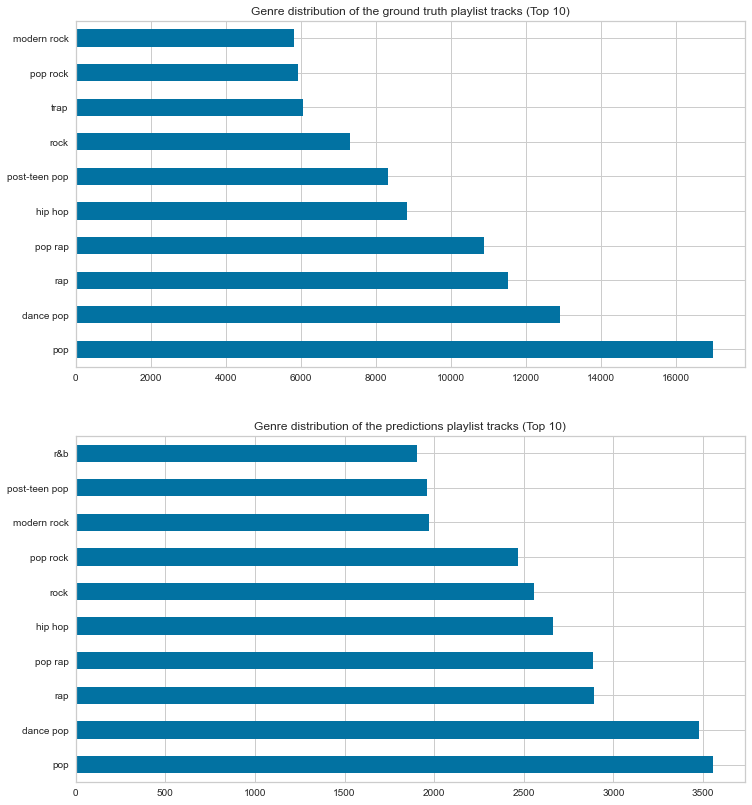

In [24]:
# Plot the genre distributions of the ground truth and predictions
plot_genre_distributions(preds_df,ground_truth_genres_df, use_avg=True)